<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/Densenet/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [2]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [3]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [4]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [7]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [8]:
net = models.densenet121(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 156MB/s]


In [9]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.5952 Acc: 0.7375
valLoss: 0.6971 Acc: 0.4833
trainLoss: 0.6024 Acc: 0.7125
valLoss: 0.6480 Acc: 0.6667
trainLoss: 0.5985 Acc: 0.7125
valLoss: 0.6255 Acc: 0.6167
trainLoss: 0.6106 Acc: 0.6958
valLoss: 0.6592 Acc: 0.6000
trainLoss: 0.5824 Acc: 0.7250
valLoss: 0.6617 Acc: 0.5500
trainLoss: 0.5765 Acc: 0.7292
valLoss: 0.5743 Acc: 0.7833
trainLoss: 0.5696 Acc: 0.7417
valLoss: 0.5682 Acc: 0.8000
trainLoss: 0.5538 Acc: 0.7708
valLoss: 0.5831 Acc: 0.7500
trainLoss: 0.5588 Acc: 0.7542
valLoss: 0.5455 Acc: 0.8167
trainLoss: 0.5507 Acc: 0.7542
valLoss: 0.5172 Acc: 0.8167
trainLoss: 0.5476 Acc: 0.7625
valLoss: 0.5261 Acc: 0.8500
trainLoss: 0.5444 Acc: 0.7583
valLoss: 0.5591 Acc: 0.7500
trainLoss: 0.5411 Acc: 0.7458
valLoss: 0.5234 Acc: 0.8000
trainLoss: 0.5217 Acc: 0.7958
valLoss: 0.4772 Acc: 0.8833
trainLoss: 0.5181 Acc: 0.8000
valLoss: 0.4847 Acc: 0.8500
trainLoss: 0.5199 Acc: 0.8125
valLoss: 0.4944 Acc: 0.8833
trainLoss: 0.5160 Acc: 0.808

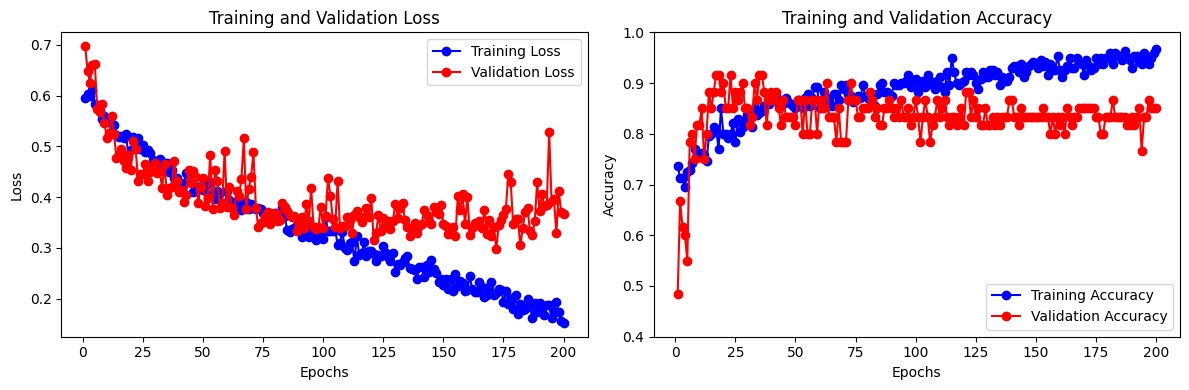

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.95      0.85      0.90        47
         out       0.61      0.85      0.71        13

    accuracy                           0.85        60
   macro avg       0.78      0.85      0.80        60
weighted avg       0.88      0.85      0.86        60

==========Cross Validation Fold 2==========
trainLoss: 0.6536 Acc: 0.6208
valLoss: 0.6277 Acc: 0.6833
trainLoss: 0.6211 Acc: 0.6917
valLoss: 0.5749 Acc: 0.8333
trainLoss: 0.5852 Acc: 0.7458
valLoss: 0.5455 Acc: 0.8833
trainLoss: 0.5485 Acc: 0.8208
valLoss: 0.4983 Acc: 0.9500
trainLoss: 0.5205 Acc: 0.8417
valLoss: 0.4490 Acc: 0.9500
trainLoss: 0.4997 Acc: 0.8667
valLoss: 0.4389 Acc: 0.9833
trainLoss: 0.4812 Acc: 0.9000
valLoss: 0.4263 Acc: 0.9667
trainLoss: 0.4816 Acc: 0.8708
valLoss: 0.4356 Acc: 0.9667
trainLoss: 0.4542 Acc: 0.8833
valLoss: 0.3990 Acc: 0.9833
trainLoss: 0.4417 Acc: 0.8958
valLoss: 0.4183 Acc: 0.9667
trainLoss: 0.4324 Acc: 0

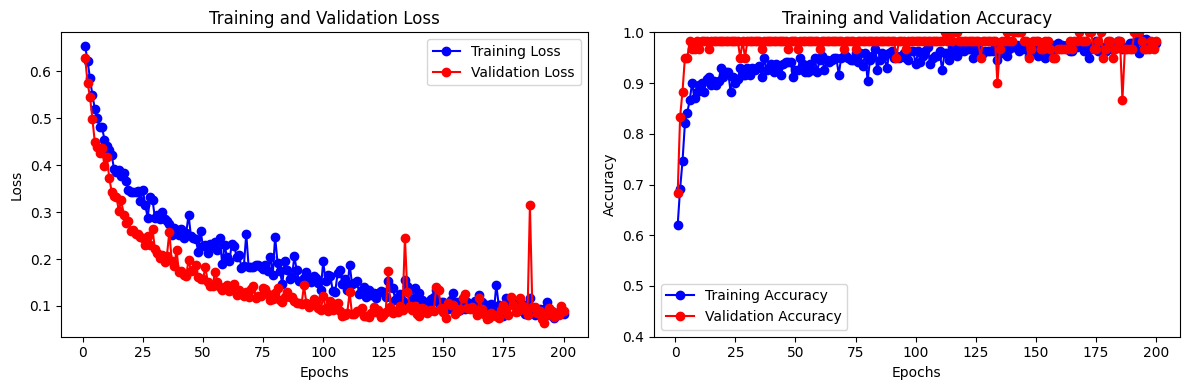

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        48
         out       1.00      0.92      0.96        12

    accuracy                           0.98        60
   macro avg       0.99      0.96      0.97        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 3==========
trainLoss: 0.6603 Acc: 0.7250
valLoss: 0.5743 Acc: 0.7667
trainLoss: 0.5689 Acc: 0.8083
valLoss: 0.4924 Acc: 0.8833
trainLoss: 0.4880 Acc: 0.8875
valLoss: 0.4268 Acc: 0.9500
trainLoss: 0.4412 Acc: 0.9333
valLoss: 0.3760 Acc: 0.9667
trainLoss: 0.4032 Acc: 0.9500
valLoss: 0.3358 Acc: 0.9667
trainLoss: 0.3688 Acc: 0.9500
valLoss: 0.3119 Acc: 0.9833
trainLoss: 0.3539 Acc: 0.9375
valLoss: 0.2801 Acc: 0.9667
trainLoss: 0.3402 Acc: 0.9458
valLoss: 0.2845 Acc: 0.9500
trainLoss: 0.3271 Acc: 0.9500
valLoss: 0.2554 Acc: 0.9833
trainLoss: 0.3012 Acc: 0.9542
valLoss: 0.2459 Acc: 0.9833
trainLoss: 0.2766 Acc: 0

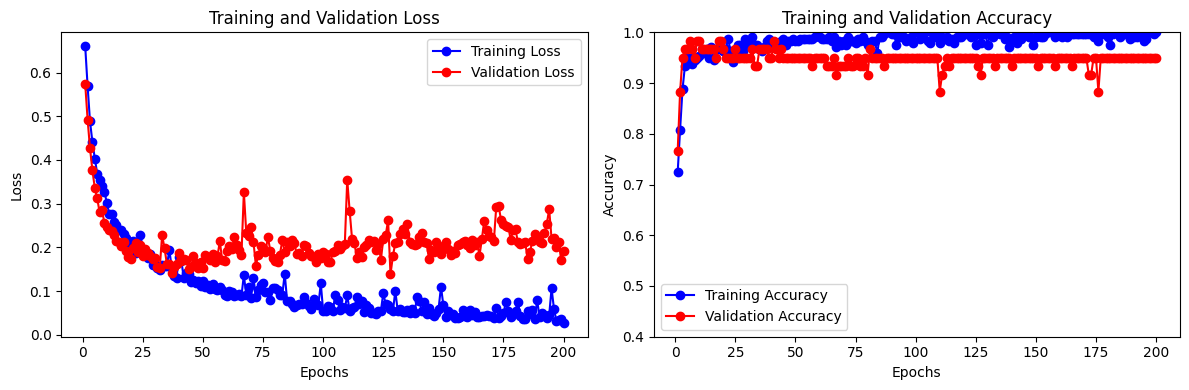

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      0.95      0.96        42
         out       0.89      0.94      0.92        18

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.95      0.95      0.95        60

==========Cross Validation Fold 4==========
trainLoss: 0.6889 Acc: 0.7583
valLoss: 0.6464 Acc: 0.7333
trainLoss: 0.5520 Acc: 0.7583
valLoss: 0.4851 Acc: 0.7333
trainLoss: 0.4479 Acc: 0.8000
valLoss: 0.3866 Acc: 0.8333
trainLoss: 0.4031 Acc: 0.8625
valLoss: 0.3241 Acc: 0.9500
trainLoss: 0.3431 Acc: 0.9125
valLoss: 0.3020 Acc: 0.9667
trainLoss: 0.3152 Acc: 0.9208
valLoss: 0.2376 Acc: 1.0000
trainLoss: 0.2884 Acc: 0.9500
valLoss: 0.2203 Acc: 1.0000
trainLoss: 0.2531 Acc: 0.9667
valLoss: 0.2028 Acc: 1.0000
trainLoss: 0.2229 Acc: 0.9792
valLoss: 0.1833 Acc: 1.0000
trainLoss: 0.2207 Acc: 0.9708
valLoss: 0.1820 Acc: 1.0000
trainLoss: 0.2230 Acc: 0

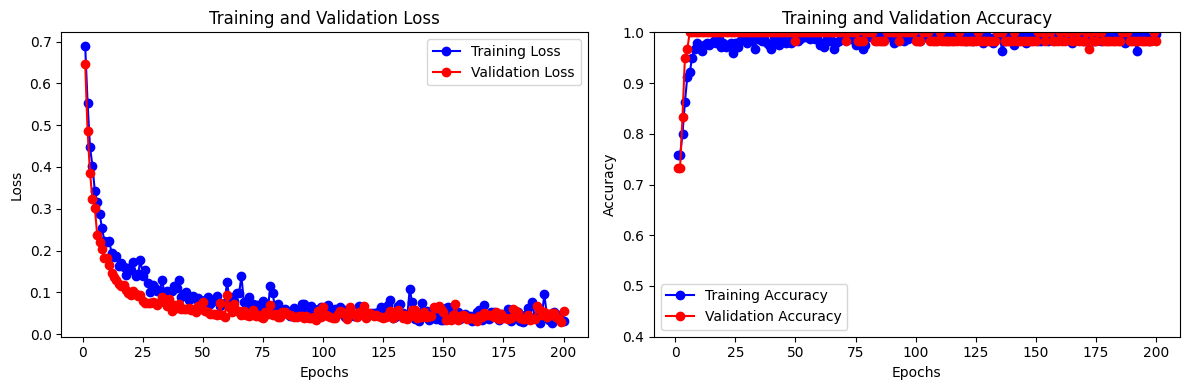

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        44
         out       1.00      0.94      0.97        16

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 5==========
trainLoss: 0.7249 Acc: 0.4667
valLoss: 0.6283 Acc: 0.7167
trainLoss: 0.5822 Acc: 0.8250
valLoss: 0.5161 Acc: 0.9833
trainLoss: 0.4859 Acc: 0.9625
valLoss: 0.4299 Acc: 1.0000
trainLoss: 0.4129 Acc: 0.9708
valLoss: 0.3777 Acc: 1.0000
trainLoss: 0.3710 Acc: 0.9750
valLoss: 0.3032 Acc: 1.0000
trainLoss: 0.3307 Acc: 0.9750
valLoss: 0.2723 Acc: 1.0000
trainLoss: 0.3112 Acc: 0.9875
valLoss: 0.2471 Acc: 1.0000
trainLoss: 0.2629 Acc: 0.9833
valLoss: 0.2315 Acc: 1.0000
trainLoss: 0.2566 Acc: 0.9833
valLoss: 0.2277 Acc: 1.0000
trainLoss: 0.2504 Acc: 0.9750
valLoss: 0.1861 Acc: 1.0000
trainLoss: 0.2101 Acc: 0

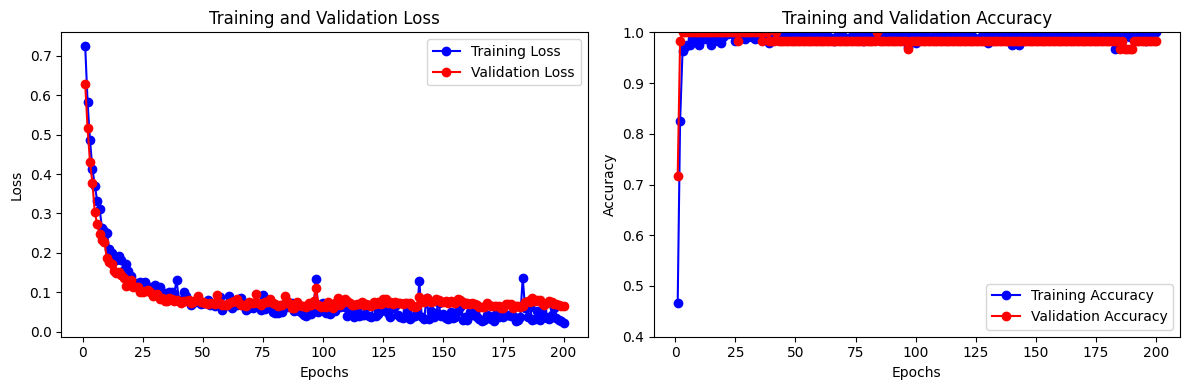

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        45
         out       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



In [10]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.classifier = nn.Linear(net.classifier.in_features, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))

In [11]:
# ライブラリのバージョンを確認する
import matplotlib
import numpy
import torch
import torchvision
import pandas
import sklearn

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", numpy.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("pandas version:", pandas.__version__)
print("sklearn version:", sklearn.__version__)


matplotlib version: 3.7.1
numpy version: 1.26.4
torch version: 2.3.0+cpu
torchvision version: 0.18.0+cpu
pandas version: 2.1.4
sklearn version: 1.3.2


Grand-cam class

In [12]:
target_layer = net.classifier[6]
feature, feature_grad = None, None

# フック関数
def forward_hook(module, inputs, outputs):
    global feature
    feature = outputs.detach().cpu()

def backward_hook(module, grad_inputs, grad_outputs):
    global feature_grad
    feature_grad = grad_outputs[0].detach().cpu()

# フックの登録
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

TypeError: 'Linear' object is not subscriptable